In [1]:
# This will import the autoreload extension
%load_ext autoreload

# This will set autoreload to reload all modules (excluding those that can't be reloaded)
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
from SARLens.processor.focus import coarseRDA
from SARLens.utils.io import load, plot_with_cdf
import torch
from pathlib import Path 

# setting device:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
folderPath = '/Data_large/marine/PythonProjects/AutoFocusNet/Data/CALIFORNIA'

def find_dat_files(fold):
    f = Path(fold)
    fList = [x for x in f.glob('**/*.dat')]
    fList = [x for x in fList if x.name.startswith('s1')]
    fList = [x for x in fList if 'annot' not in x.name]
    fList = [x for x in fList if 'index' not in x.name]
    fList = [x for x in fList if 'vh' in x.name]
    fdict = {x.parent.name:x for x in fList}
    return fdict


fdict = find_dat_files(folderPath)
fnames = list(fdict.keys())

# Focusing:

#### Decoding

In [9]:
idx = 0
input_file = fdict[fnames[idx]]
output_folder = f'{folderPath}/decoded/{fnames[idx]}'

!python -m SARLens.processor.decode -i {input_file} -o {output_folder}

Decoding Level 0 file...
decoded: 29018 packets [01:38, 293.74 packets/s] 
Starting an incomplete sub-commutated data cycle. (first index: 47.
Incomplete sub-commutated data cycle: 0
Incomplete sub-commutated data cycle: 2
Incomplete sub-commutated data cycle: 31
Incomplete sub-commutated data cycle: 61
Incomplete sub-commutated data cycle: 91
Incomplete sub-commutated data cycle: 121
Incomplete sub-commutated data cycle: 151
Incomplete sub-commutated data cycle: 181
Incomplete sub-commutated data cycle: 211
Incomplete sub-commutated data cycle: 241
Incomplete sub-commutated data cycle: 271
Incomplete sub-commutated data cycle: 301
Incomplete sub-commutated data cycle: 331
Incomplete sub-commutated data cycle: 361
Incomplete sub-commutated data cycle: 391
Incomplete sub-commutated data cycle: 421
Incomplete sub-commutated data cycle: 451
Incomplete sub-commutated data cycle: 465


### RDA:

In [12]:
def find_decoded_pkts(pkt_n, folder):
    f = list(Path(folder).iterdir())
    # meta:
    m = [x for x in f if 'metadata' in x.name]
    m = [x for x in m if f'pkt_{pkt_n}' in x.name]
    # prod:
    p = [x for x in f if not 'metadata' in x.name]
    p = [x for x in p if f'pkt_{pkt_n}' in x.name]
    # eph:
    e = [x for x in f if 'ephemeris' in x.name]
    
    return load(p[0]), load(m[0]), load(e[0])

In [17]:
from SARLens.processor.focus import coarseRDA

radar_data, metadata, ephemeris = find_decoded_pkts(pkt_n=1, folder=output_folder)  

# init
radar_data = torch.from_numpy(radar_data).to("cpu")

RadarProcessor = coarseRDA(
    raw_data={'echo':radar_data[:,:], 'ephemeris':ephemeris, 'metadata':metadata}, 
    verbose=False, 
    backend='torch'
)

RadarProcessor.data_focus()

Selected device: cpu
Elapsed time for _prompt_tx_replica: 0.2327 seconds
Elapsed time for fft2D: 11.3381 seconds
Elapsed time for get_range_filter: 0.1100 seconds
Elapsed time for _compute_effective_velocities: 0.3959 seconds


ValueError: operands could not be broadcast together with shapes (28610,) (25764,408) 

In [20]:
RadarProcessor.get_RCMC()

Elapsed time for _compute_effective_velocities: 0.4728 seconds


ValueError: operands could not be broadcast together with shapes (28610,) (25764,408) 

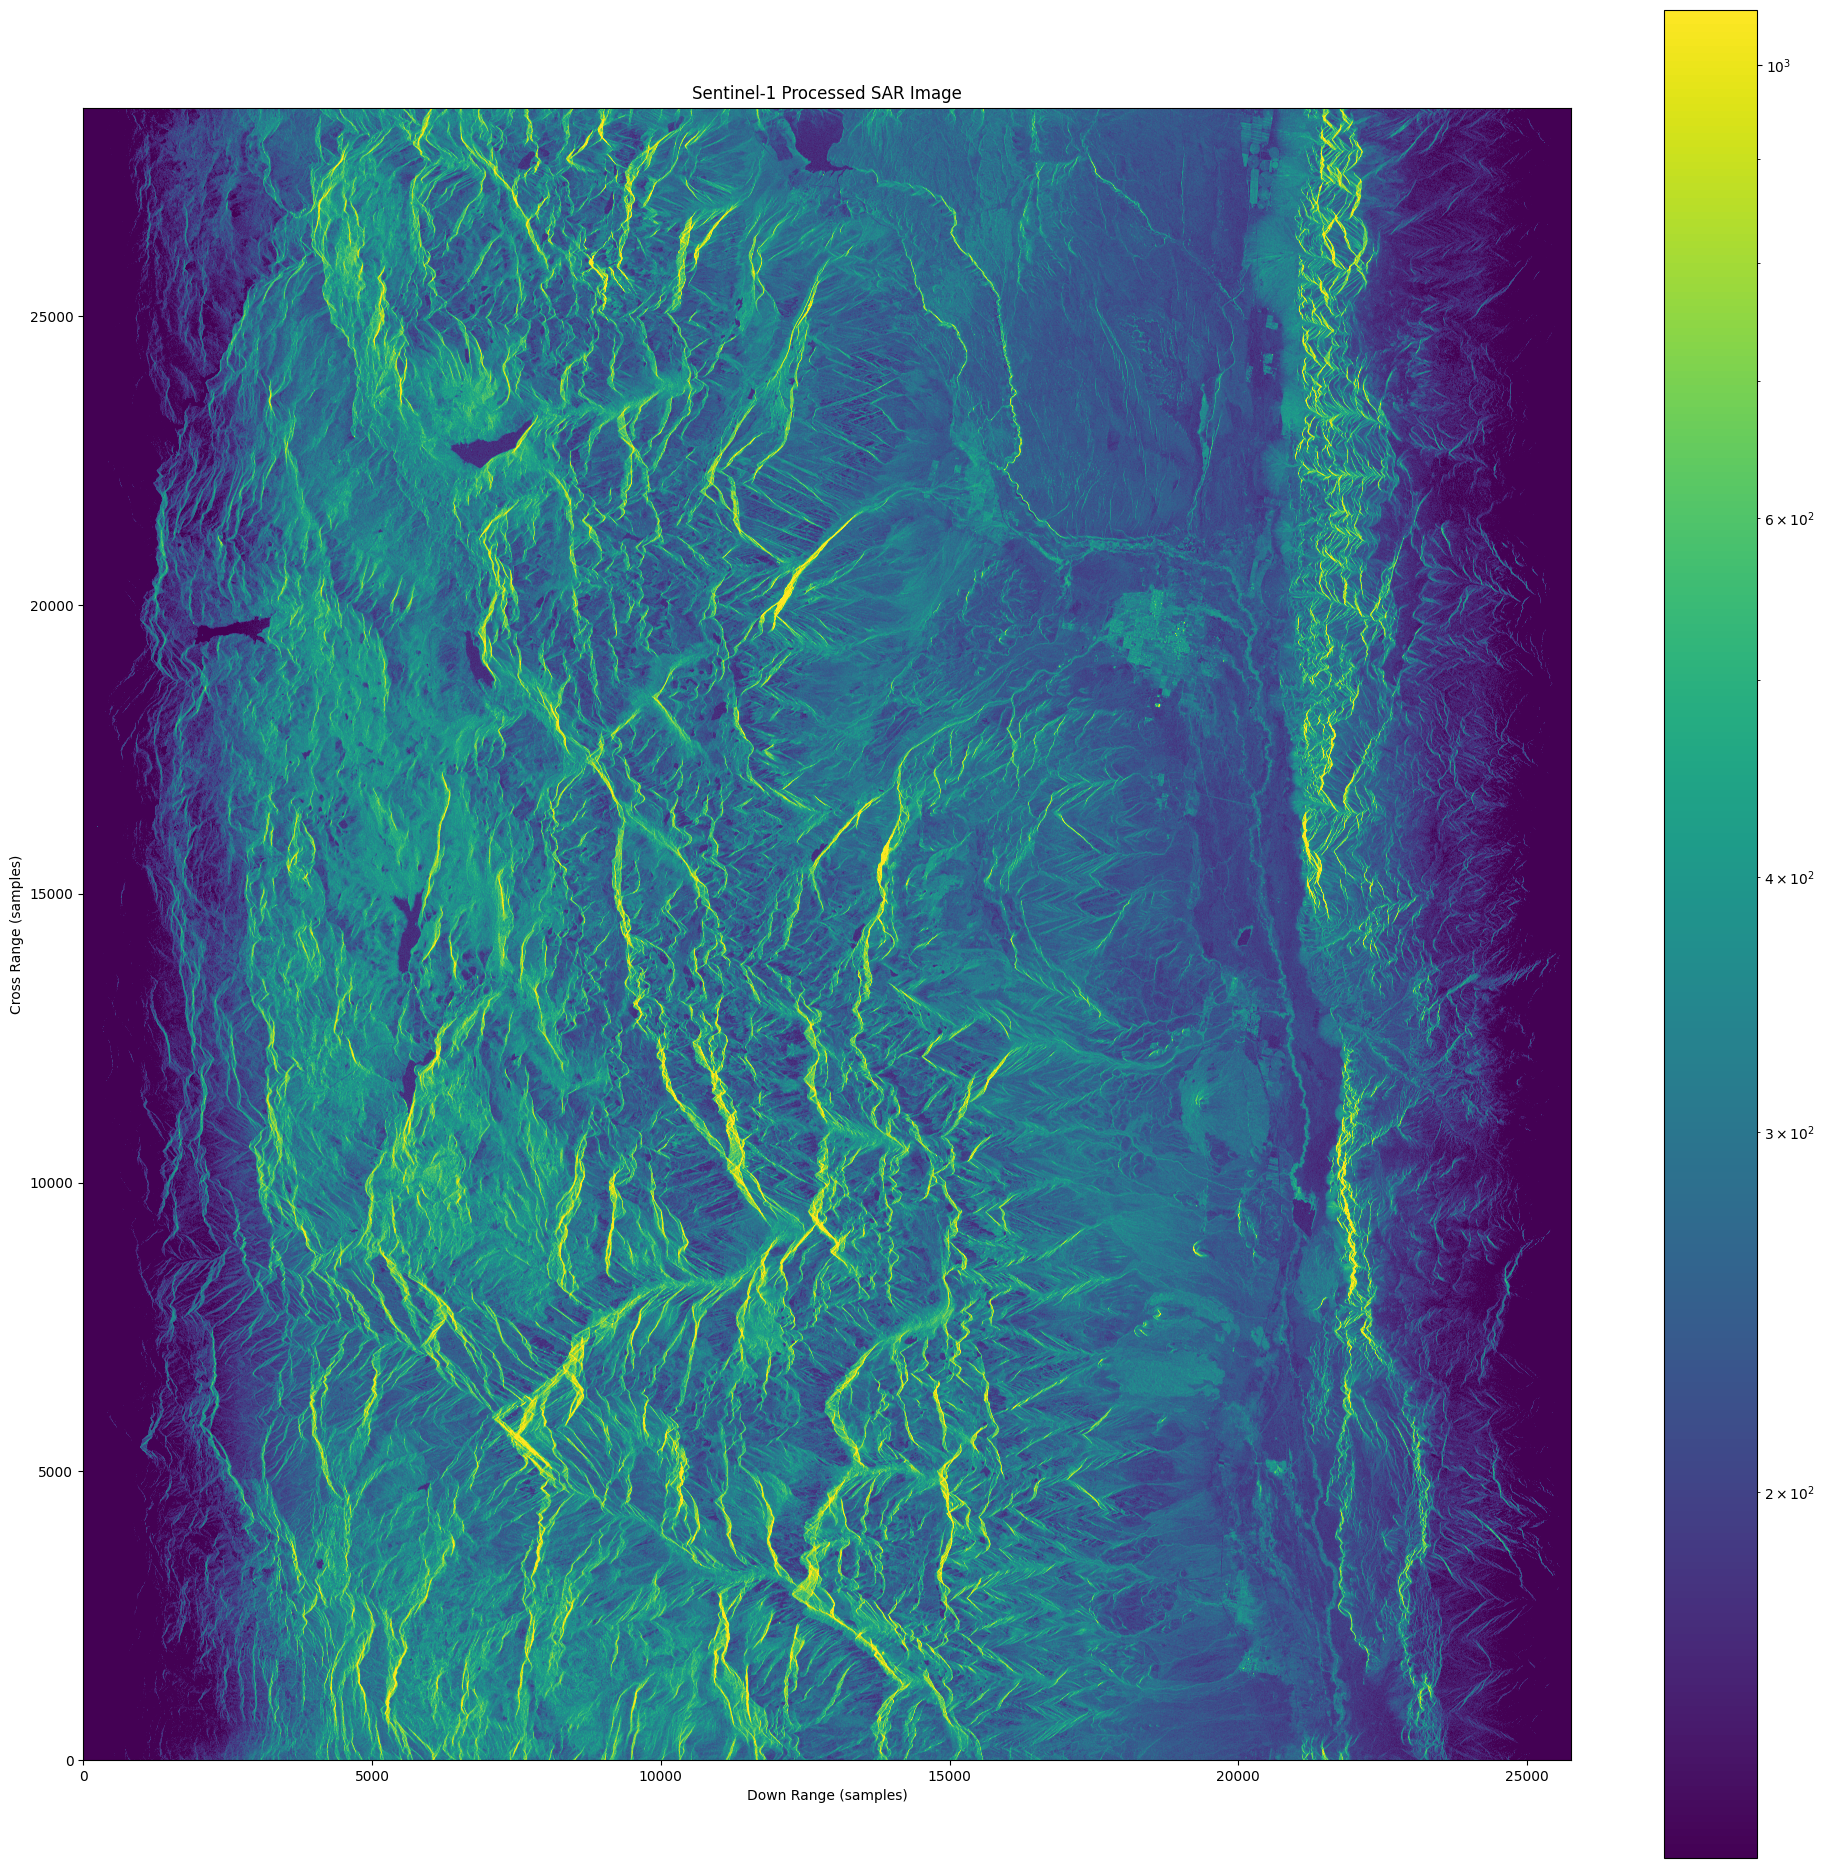

In [ ]:
plot_with_cdf(RadarProcessor.radar_data, (24,24))